## OVERVIEW
---
* Data Visualization
* COVID-19 Datewise and CountryWise Analysis
* Feature Engineering & Data Preprocessing
* Forecasting With Keras LSTM Model

In [4]:


#data manipulation library
import numpy as np
import pandas as pd
import random


#data visualization lib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import boxcox
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#DEEP LEARNING LIB
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.optimizers import RMSprop

#METRICS
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, r2_score,mean_absolute_error,mean_squared_error




import warnings
warnings.filterwarnings('ignore')

In [5]:
#get the data
df = pd.read_csv('data/covid_19_clean_complete.csv')

In [7]:
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0,0,Africa


## DATA BASIC INFORMATION
---

#### SHOW DATASET SHAPE AND FEATURES DATA TYPES

In [8]:
#show
print('Size of Data: ', df.shape)
print('\nFeature Data-Types:\n', df.dtypes)

Size of Data:  (39933, 10)

Feature Data-Types:
 Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
Confirmed           int64
Deaths              int64
Recovered           int64
Active              int64
WHO Region         object
dtype: object


### CHECKING NULL DATA
---

In [9]:
#show null data
pd.DataFrame(data=df.isnull().sum(), columns=['number of null data'])

,number of null data
Province/State,27999
Country/Region,0
Lat,0
Long,0
Date,0
Confirmed,0
Deaths,0
Recovered,0
Active,0
WHO Region,0


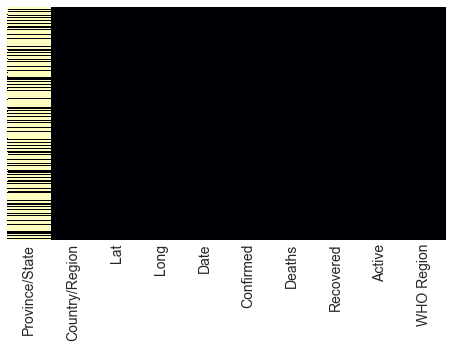

In [10]:
plt.figure(figsize=(7,4))
sns.heatmap(df.isnull(), cmap='magma', yticklabels=False, cbar=False )

In [11]:
print('Missing Data of Province/State: ', (df['Province/State'].isnull().sum())/df['Confirmed'].count() * 100, '%')

Missing Data of Province/State:  70.11494252873564 %


* Most of the data on Province/State feature are null and using it to train a model will just mess the balance on our data and will only produce a bad result, so I'll just drop it.

In [12]:
#dropping lat and long feature because i will not use them in this notebook, maybe next time i'll choropleth to plot them
df.drop(['Lat','Long', 'Province/State'], axis=1,inplace=True)

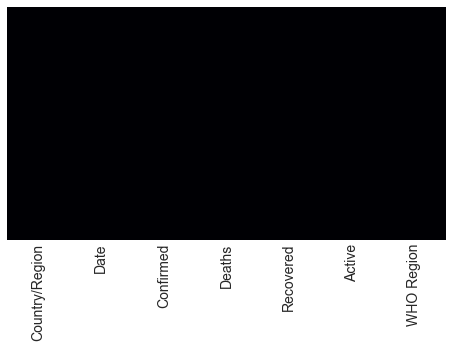

In [13]:
#CHECK THE HEATMAT OF NULL DATA AGAIN

plt.figure(figsize=(7,4))
sns.heatmap(df.isnull(), cmap='magma',cbar=False, yticklabels=False)

## DATEWISE ANALYSIS
---

In [14]:
#convert date to datetime object
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [15]:
datetime_an = df.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [16]:
#add day feature on a datetime_an df
datetime_an['Days'] = datetime_an.index-datetime_an.index.min()

In [17]:
#show new df
datetime_an.Confirmed.max()

9097902

#### SHOW INFORMATION ABOUT COVID 19

In [18]:
index = ['Number Of Countries With COVID-19', 'Total Confirmed Cases WorldWide', 'Total Number of Recovered Cases WorldWide'
        , 'Total Number of Deaths WorldWide', 'Total Number of Active Cases Wordwide', 'Total Number of Closed Cases WorldWide'
        , 'Number of Confirmed Cases as of '+ str(df.Date.iloc[-1]), 'Number of Recovered Cases as of ' + str(df.Date.iloc[-1]), 'Number of Death Cases as of '+ str(df.Date.iloc[-1])]

data = [len(df['Country/Region'].unique()), datetime_an.Confirmed.max(), datetime_an.Recovered.max(), 
        datetime_an.Deaths.max(), (
        datetime_an.Confirmed.max() - datetime_an.Recovered.max() - datetime_an.Deaths.max()), 
         datetime_an.Recovered.max() + datetime_an.Deaths.max(),
        datetime_an.Confirmed.iloc[-1] - datetime_an.Confirmed.iloc[-2],
        datetime_an.Recovered.iloc[-1] - datetime_an.Recovered.iloc[-2], 
        datetime_an.Deaths.iloc[-1] - datetime_an.Deaths.iloc[-2]]

In [19]:
basic_info = pd.DataFrame(index=index, data=data, columns=['Data'])
basic_info

,Data
Number Of Countries With COVID-19,187
Total Confirmed Cases WorldWide,9097902
Total Number of Recovered Cases WorldWide,4459666
Total Number of Deaths WorldWide,472155
Total Number of Active Cases Wordwide,4166081
Total Number of Closed Cases WorldWide,4931821
Number of Confirmed Cases as of 2020-06-22,141999
Number of Recovered Cases as of 2020-06-22,91233
Number of Death Cases as of 2020-06-22,3774


### DISTRIBUTION OF CASES
---

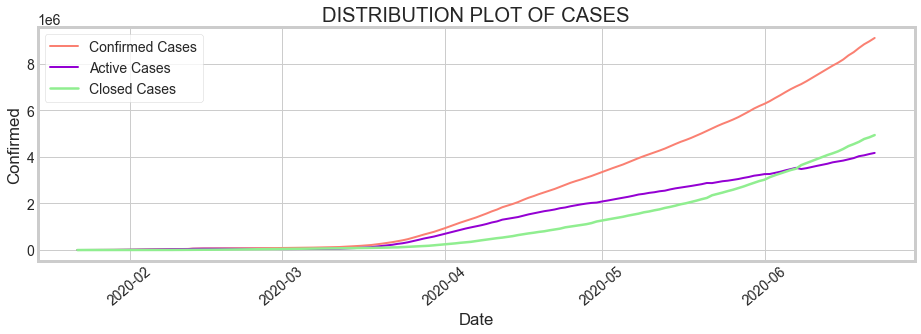

In [20]:
plt.figure(figsize=(14,4))
plt.xticks(rotation=40)
sns.lineplot(datetime_an.index, datetime_an.Confirmed, lw=2, color='salmon')
sns.lineplot(datetime_an.index, (datetime_an.Confirmed-(datetime_an.Recovered + datetime_an.Deaths)), lw=2, color='darkviolet')
sns.lineplot(datetime_an.index, (datetime_an.Recovered + datetime_an.Deaths), lw=2.5, color='lightgreen')


plt.title('DISTRIBUTION PLOT OF CASES')
plt.legend(['Confirmed Cases', 'Active Cases', 'Closed Cases'])

## WEEKWISE ANALYSIS
---

Text(0, 0.5, 'Cases')

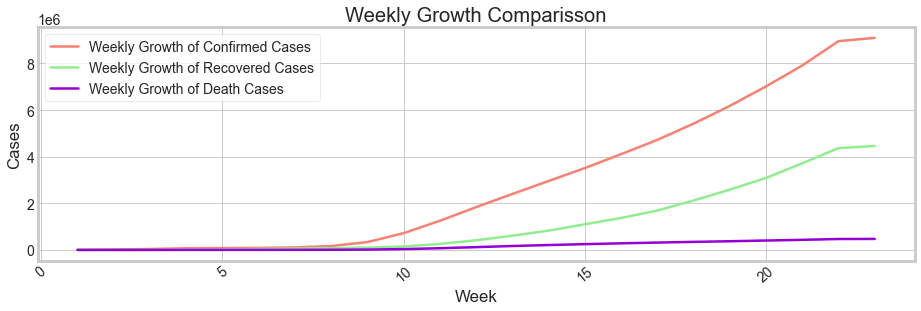

In [21]:
#set a number of weeks feature
datetime_an.index = pd.to_datetime(datetime_an.index)
datetime_an["WeekOfYear"]=datetime_an.index.weekofyear

weeklenght = len(datetime_an.index.weekofyear.unique())

week_num = np.array(range(weeklenght + 1))
week_num = list(week_num[1:])


weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]

#get the cases per week
for i in list(datetime_an["WeekOfYear"].unique()):
    weekwise_confirmed.append(datetime_an[datetime_an["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datetime_an[datetime_an["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datetime_an[datetime_an["WeekOfYear"]==i]["Deaths"].iloc[-1])
    
#show the plot
plt.figure(figsize=(14,4))
plt.xticks(rotation=40)
sns.lineplot(week_num, weekwise_confirmed, lw=2.5, color='salmon')
sns.lineplot(week_num, weekwise_recovered, lw=2.5, color='lightgreen')
sns.lineplot(week_num, weekwise_deaths, lw=2.5, color='darkviolet')

#set the labels
plt.title('Weekly Growth Comparisson')
plt.legend(['Weekly Growth of Confirmed Cases',
            'Weekly Growth of Recovered Cases',
            'Weekly Growth of Death Cases'])
plt.xlabel('Week')
plt.ylabel('Cases')

### NUMBER OF CASES PER WEEK COMPARISON
---

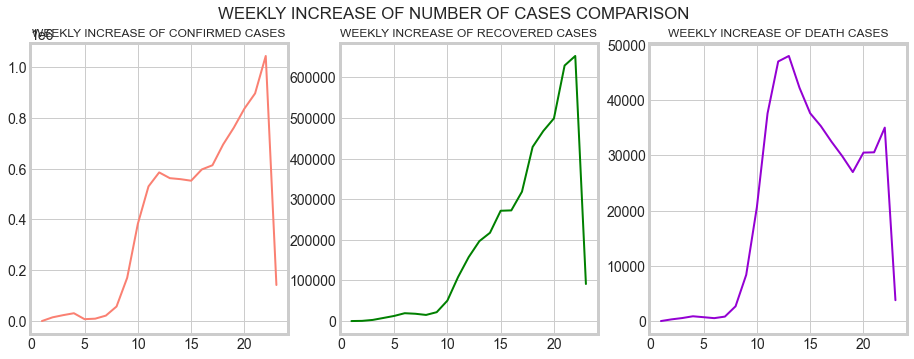

In [22]:
fig, ax = plt.subplots(1,3, figsize=(14,5))
plt.suptitle('WEEKLY INCREASE OF NUMBER OF CASES COMPARISON')
ax[0].set_title('WEEKLY INCREASE OF CONFIRMED CASES', fontsize=12)
ax[1].set_title('WEEKLY INCREASE OF RECOVERED CASES', fontsize=12)
ax[2].set_title('WEEKLY INCREASE OF DEATH CASES', fontsize=12)
sns.lineplot(x=week_num, y=pd.Series(weekwise_confirmed).diff().fillna(0), ax=ax[0], color='salmon', lw=2)
sns.lineplot(x=week_num, y=pd.Series(weekwise_recovered).diff().fillna(0), ax=ax[1], color='green', lw=2)
sns.lineplot(x=week_num, y=pd.Series(weekwise_deaths).diff().fillna(0), ax=ax[2], color='darkviolet', lw=2)

### MORTALITY AND RECOVERY RATE WORLDWIDE
---

In [23]:
datetime_an['Recovery Rate'] = (datetime_an.Recovered / datetime_an.Confirmed ) * 100
datetime_an['Mortality Rate'] = (datetime_an.Deaths/ datetime_an.Confirmed) * 100
datetime_an['Active Cases'] = (datetime_an.Confirmed - datetime_an.Recovered - datetime_an.Deaths)
datetime_an['Closed Cases'] = datetime_an.Recovered + datetime_an.Deaths

Text(0, 0.5, 'Percentage')

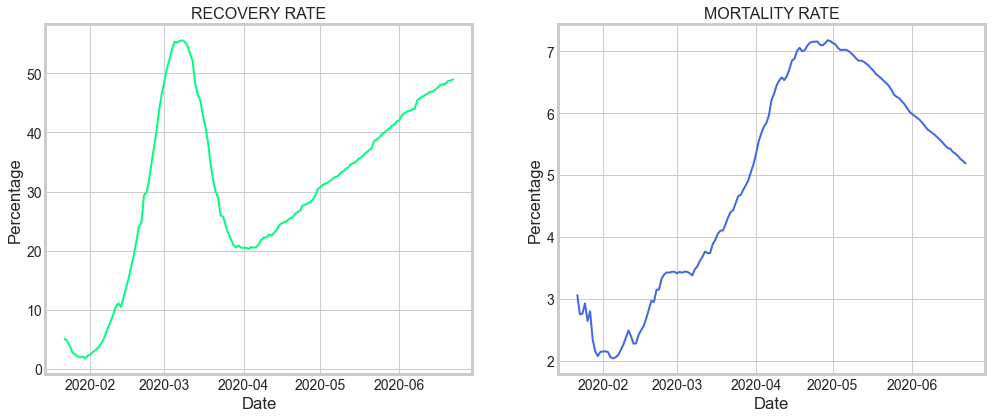

In [24]:
# fig = make_subplots(rows=1,cols=2, subplot_titles=('Recovery Rate','Mortality Rate'))
fig,ax = plt.subplots(1,2,figsize=(15,6))
sns.lineplot(x=datetime_an.index, y=(datetime_an.Recovered / datetime_an.Confirmed)*100, ax=ax[0], lw=2,color='springgreen')
sns.lineplot(x=datetime_an.index, y=(datetime_an.Deaths / datetime_an.Confirmed)*100, ax=ax[1], lw=2, color='royalblue')
ax[0].set_title('RECOVERY RATE', fontsize=16)
ax[1].set_title('MORTALITY RATE', fontsize=16)
ax[0].set_ylabel('Percentage')
ax[1].set_ylabel('Percentage')

## AVERAGE AND MEADIAN
---

### Recovery and Mortality Rate

In [25]:
pd.Series(index=['Average Recovery Rate',
                 'Average Mortality Rate', 
                 'Median Recovery Rate', 
                 'Median Mortality Rate'],
          data=[datetime_an['Recovery Rate'].mean(),
                datetime_an['Mortality Rate'].mean(),
                datetime_an['Recovery Rate'].median(),
                datetime_an['Mortality Rate'].median()])


Average Recovery Rate     30.377035
Average Mortality Rate     4.946397
Median Recovery Rate      31.310363
Median Mortality Rate      5.377072
dtype: float64

### Average Increase in Number (Confirmed, Recovered and Deaths)

In [26]:
pd.Series(index=['Average Increase in Number of Confirmed Cases',
                 'Average Increase in Number of Recovered Cases',
                 'Average Increase in Number of Death Cases'],
          data=[round(datetime_an.Confirmed.diff().fillna(0).mean()),
                round(datetime_an.Recovered.diff().fillna(0).mean()),
                round(datetime_an.Deaths.diff().fillna(0).mean())])

Average Increase in Number of Confirmed Cases    59460
Average Increase in Number of Recovered Cases    29148
Average Increase in Number of Death Cases         3086
dtype: int64

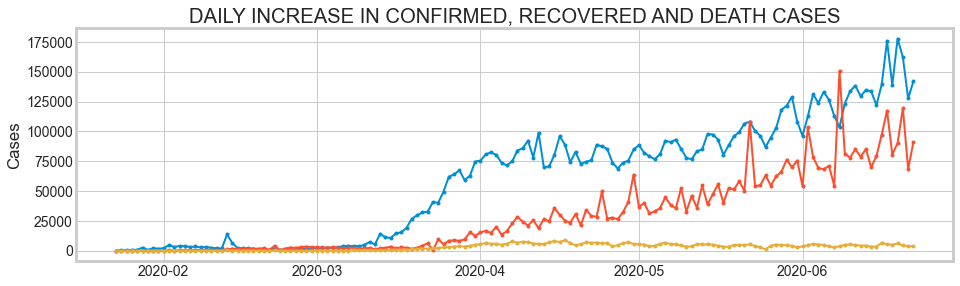

In [27]:
#show plot
plt.figure(figsize=(14,4))
plt.title('DAILY INCREASE IN CONFIRMED, RECOVERED AND DEATH CASES')
plt.ylabel('Cases')
plt.plot(datetime_an.index, datetime_an.Confirmed.diff(),marker='o', lw=2, markersize=3)
plt.plot(datetime_an.index, datetime_an.Recovered.diff(),marker='o', lw=2, markersize=3)
plt.plot(datetime_an.index, datetime_an.Deaths.diff(),marker='o', lw=2, markersize=3)

## GROWTH FACTOR
---

In [28]:
pd.Series(index=['Average Growth Factor (Confirmed Cases)',
                 'Average Growth Factor (Recovered Cases)',
                 'Average Growth Factor (Death Cases)',
                 'Median Growth Factor (Confirmed Cases)',
                 'Median Growth Factor (Recovered Cases)',
                 'Median Growth Factor (Death Cases)'],
          data=[(datetime_an.Confirmed / datetime_an.Confirmed.shift()).mean(),
                (datetime_an.Recovered / datetime_an.Recovered.shift()).mean(),
                (datetime_an.Deaths / datetime_an.Deaths.shift()).mean(),
                (datetime_an.Confirmed / datetime_an.Confirmed.shift()).median(),
                (datetime_an.Recovered / datetime_an.Recovered.shift()).median(),
                (datetime_an.Deaths / datetime_an.Deaths.shift()).median()])

Average Growth Factor (Confirmed Cases)    1.070514
Average Growth Factor (Recovered Cases)    1.086788
Average Growth Factor (Death Cases)        1.073583
Median Growth Factor (Confirmed Cases)     1.029565
Median Growth Factor (Recovered Cases)     1.045495
Median Growth Factor (Death Cases)         1.032416
dtype: float64

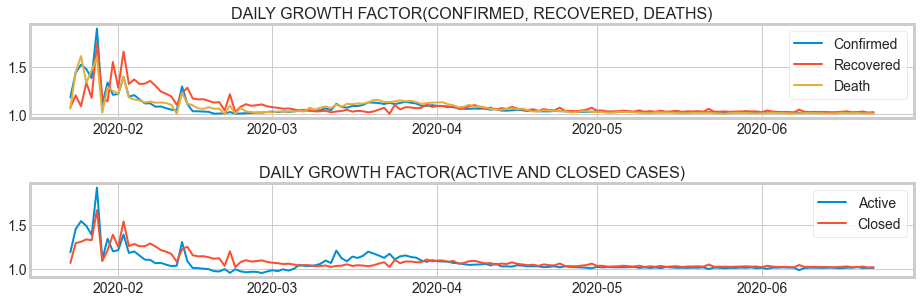

In [29]:
#SHOW PLOTS
fig, ax = plt.subplots(2,1, figsize=(14,5))
plt.tight_layout(3)
ax[0].plot(datetime_an.index, (datetime_an.Confirmed / datetime_an.Confirmed.shift()), lw=2)
ax[0].plot(datetime_an.index, (datetime_an.Recovered / datetime_an.Recovered.shift()), lw=2)
ax[0].plot(datetime_an.index, (datetime_an.Deaths / datetime_an.Deaths.shift()), lw=2)
ax[0].set_title('DAILY GROWTH FACTOR(CONFIRMED, RECOVERED, DEATHS)', fontsize=16)
ax[0].legend(['Confirmed', 'Recovered', 'Death'])

ax[1].plot(datetime_an.index, (datetime_an['Active Cases'] / datetime_an['Active Cases'].shift()), lw=2)
ax[1].plot(datetime_an.index, (datetime_an['Closed Cases'] / datetime_an['Closed Cases'].shift()), lw=2)
ax[1].set_title('DAILY GROWTH FACTOR(ACTIVE AND CLOSED CASES)', fontsize=16)
ax[1].legend(['Active', 'Closed'])

## ANALYSIS BY COUNTRY
---

In [30]:
countrywise = df[df["Date"]==df["Date"].max()].groupby(['Country/Region']).agg({'Confirmed':'sum', 'Recovered':'sum','Deaths':'sum'}).sort_values(['Confirmed'],ascending=False)

In [31]:
# Top 5 Countries
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [32]:
#function that gerate hex color
def generate_hexcolor(number_of_colors):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return color

Text(0.5, 1.0, 'Top 20 countries as per Number of Death Cases')

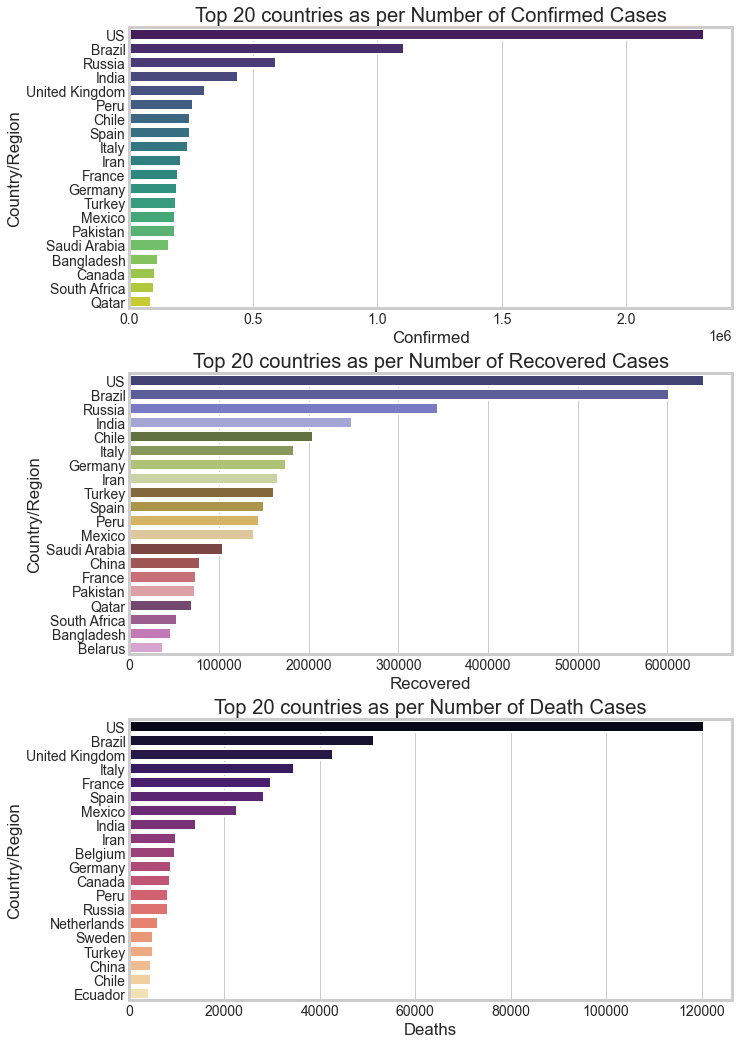

In [49]:

top_count_confirmed = countrywise.sort_values(['Confirmed'],ascending=False).head(20)
top_count_recov = countrywise.sort_values(['Recovered'],ascending=False).head(20)
top_count_deaths = countrywise.sort_values(['Deaths'],ascending=False).head(20)

#show plot
fig, ax = plt.subplots(3,1,figsize=(10,15))
plt.tight_layout(3)

sns.barplot(y=top_count_confirmed.index,x=top_count_confirmed.Confirmed, lw=2, palette='viridis' , ax=ax[0])
sns.barplot(y=top_count_recov.index,x=top_count_recov.Recovered, lw=2, palette='tab20b' , ax=ax[1])
sns.barplot(y=top_count_deaths.index,x=top_count_deaths.Deaths, lw=2, palette='magma' , ax=ax[2])

ax[0].set_title('Top 20 countries as per Number of Confirmed Cases')
ax[1].set_title('Top 20 countries as per Number of Recovered Cases')
ax[2].set_title('Top 20 countries as per Number of Death Cases')


### TOP 20 COUNTRIES ACCORDING TO HIGH MORTALITY RATE AND RECOVERY RATE WITH MORE THAN 500 CONFIRMED CASES
---

In [50]:
high_recovery = countrywise[countrywise['Confirmed']>500].sort_values(['Recovery'],ascending =False).head(20)
high_mortality = countrywise[countrywise['Confirmed']>500].sort_values(['Mortality'],ascending=False).head(20)

Text(0.5, 1.0, 'Top 20 countries According High Mortality Rate')

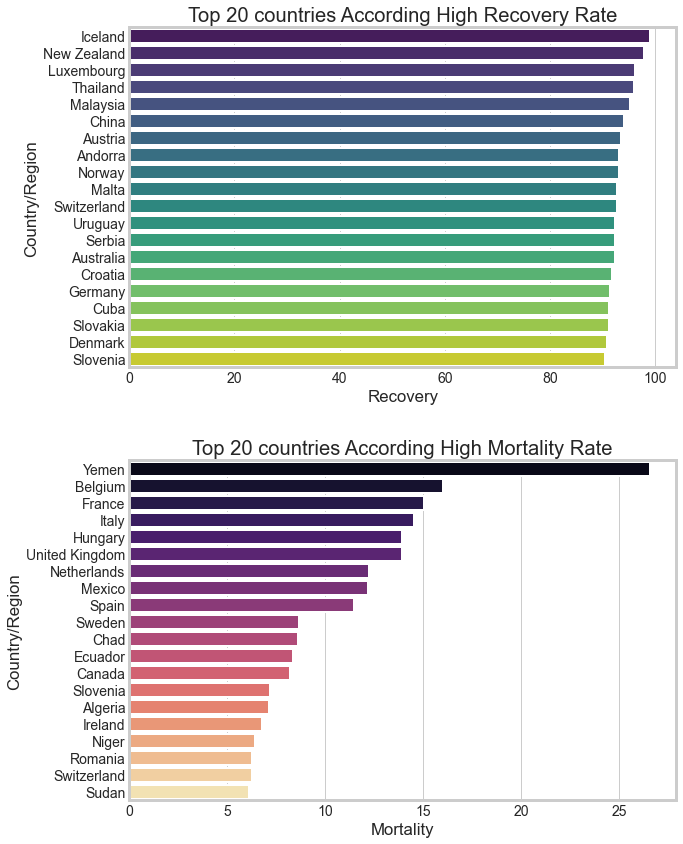

In [56]:
#show plot
fig, ax = plt.subplots(2,1,figsize=(10,13))
plt.tight_layout(5)

sns.barplot(y=high_recovery.index,x=high_recovery.Recovery, lw=2, palette='viridis' , ax=ax[0])
sns.barplot(y=high_mortality.index,x=high_mortality.Mortality, lw=2, palette='magma' , ax=ax[1])

ax[0].set_title('Top 20 countries According High Recovery Rate')
ax[1].set_title('Top 20 countries According High Mortality Rate')


### COUNTRIES WITH NO DEATH CASES WITH MORE THAN 100 CONFIRMED CASES
---

In [34]:
no_death_case = countrywise[(countrywise['Confirmed']>100) & 
                            (countrywise['Deaths'] == 0)]

In [35]:
no_death_case

,Confirmed,Recovered,Deaths,Mortality,Recovery
Country/Region,,,,,
Uganda,774,631,0,0.0,81.524548
Vietnam,349,328,0,0.0,93.982808
Mongolia,215,158,0,0.0,73.488372
Eritrea,143,39,0,0.0,27.272727
Cambodia,130,127,0,0.0,97.692308


### TOP 20 COUNTRIES WITH MOST ACTIVE CASES
---

In [36]:
countrywise["Active Cases"]=(countrywise["Confirmed"]-countrywise["Recovered"]-countrywise["Deaths"])
countrywise["Outcome Cases"]=(countrywise["Recovered"]+countrywise["Deaths"])

most_active = countrywise.sort_values(['Active Cases'], ascending=False).head(20)

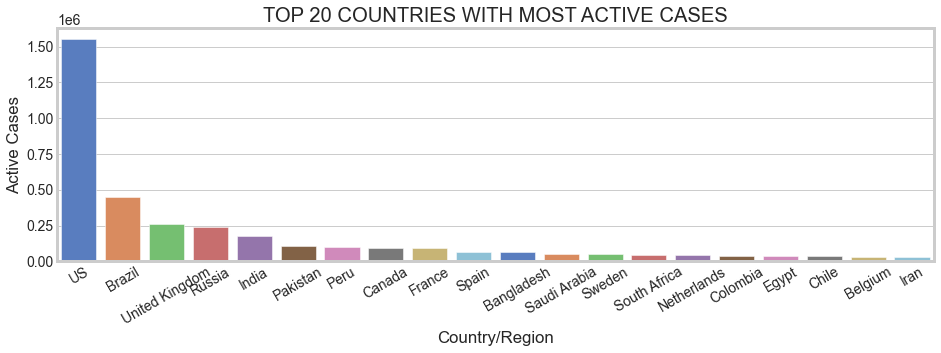

In [37]:
plt.figure(figsize=(14,4))
plt.title('TOP 20 COUNTRIES WITH MOST ACTIVE CASES')
plt.xticks(rotation=30)
sns.barplot(most_active.index, most_active['Active Cases'], palette='muted')


### COUNTRIES WITH HIGHEST SURVIVAL PROBABILITY WITH 1000 CONFIRMED CASES
---

In [38]:
countrywise["Survival Probability"]=(1-(countrywise["Deaths"]/countrywise["Confirmed"]))*100
surv_prob = countrywise[countrywise['Confirmed']>1000].sort_values(['Survival Probability'], ascending=False).head(15)

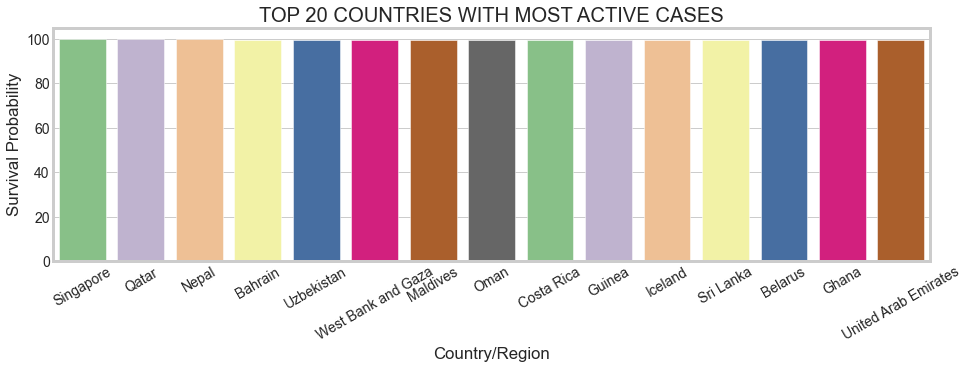

In [39]:
plt.figure(figsize=(14,4))
plt.title('TOP 20 COUNTRIES WITH HIGHEST SURVIIVAL PROBABILITY')
plt.xticks(rotation=30)
sns.barplot(surv_prob.index, surv_prob['Survival Probability'], palette='Accent')


### (SURVIVAL AND DEATH PROBALITY) MEAN AND MEDIAN ACROSS ALL COUNTRIES
---

In [40]:
index = ['Mean Survival Probability Across all Countries', 
         'Median Survival Probability Across all Countries',
         'Mean Death Probability Across all Countries',
         'Median Death Probability Across all Countries']

data = [countrywise['Survival Probability'].mean(),
        countrywise['Survival Probability'].median(),
        (100-countrywise['Survival Probability']).mean(),
        (100-countrywise['Survival Probability']).median()]

In [41]:
pd.Series(index=index, data=data)

Mean Survival Probability Across all Countries      96.704533
Median Survival Probability Across all Countries    97.872340
Mean Death Probability Across all Countries          3.295467
Median Death Probability Across all Countries        2.127660
dtype: float64

* Note: In this notebook I will only Forecast the Confirmed cases worldwide.

## DATA PREPROCESSING
---

In [42]:
#get date and confirmed cases
data = datetime_an.drop( ['Recovered', 'Deaths', 'Days', 'WeekOfYear',
       'Recovery Rate', 'Mortality Rate', 'Active Cases', 'Closed Cases'], axis=1)
data = data.reset_index()
data.columns = ['date', 'confirmed_cases']

### FEATURE ENGINEERING

In [43]:
#extract the date
data['day'] = data.date.dt.day
data['dayofweek'] = data.date.dt.dayofweek
data['week'] = data.date.dt.week
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year

In [44]:
#create a lag feature
for i in range(1,8):
    data['lag_'+str(i)] = data['confirmed_cases'].shift(i).fillna(0)

#### PLOT ACF AND PACF

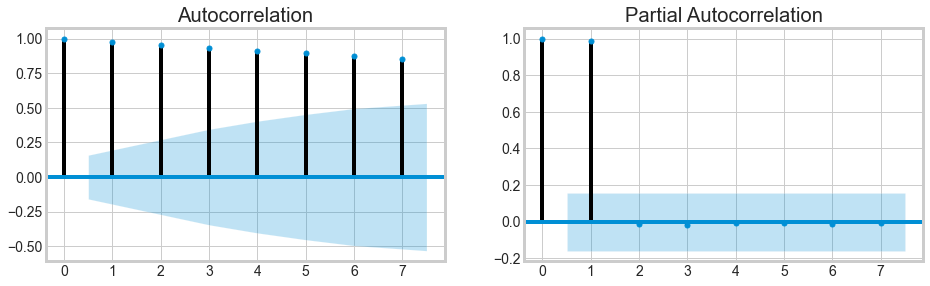

In [45]:
fig,ax = plt.subplots(1,2,figsize=(14,4))
plot_acf(data.confirmed_cases, lags=7, ax=ax[0])
plot_pacf(data.confirmed_cases, lags=7, ax=ax[1])
plt.show()

### INSIGHTS
---
* The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.

* The partial autocorrelation function shows a high correlation with the first lag and lesser correlation with the second and third lag.

In [46]:
#droppping date feature
data.drop('date', axis=1, inplace=True)
#check the new dataframe
data.head()

,confirmed_cases,day,dayofweek,week,month,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,555,22,2,4,1,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,654,23,3,4,1,2020,555.0,0.0,0.0,0.0,0.0,0.0,0.0
2,941,24,4,4,1,2020,654.0,555.0,0.0,0.0,0.0,0.0,0.0
3,1434,25,5,4,1,2020,941.0,654.0,555.0,0.0,0.0,0.0,0.0
4,2118,26,6,4,1,2020,1434.0,941.0,654.0,555.0,0.0,0.0,0.0


### DATA TRANSFORMATION

In [111]:
#normalizing feature except for confimed cases
scaler_f = StandardScaler()
scaled_feat = scaler_f.fit_transform(data.drop('confirmed_cases', axis=1))
scaler_l = StandardScaler()
scaled_target = scaler_l.fit_transform(data['confirmed_cases'].values.reshape(-1,1))

X = pd.DataFrame(scaled_feat, columns=['day', 'dayofweek', 'week', 'month', 'year', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'])
y = scaled_target

#splitting the data (i will forecast the next 10 days, so i will remove now the last 10 days value on our training data)
X_train , X_test = X[:-10], X[-10:]
y_train , y_test = y[:-10], data['confirmed_cases'][-10:]

y_train = y_train.reshape(-1)

## PREDICTIVE MODELLING
---

### LSTM MODEL
---

In [3]:
#### TO BE CONTINUED, i'll update this notebook next time.